# fetch_prom_stats

Первичный запрос данных из Prometheus и первичный EDA.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

In [2]:
from src.data_loader import fetch_frame
# df = fetch_frame()
df = fetch_frame(
    use_cache=True,
    cache_filename="only_common_delayp90.parquet"
)
print(df.head())

print(df.info())

print(df.describe())

print(df.isnull().sum())


                     common_delay_p90
ts                                   
2025-04-27 18:00:30       2394.210526
2025-04-27 18:00:45       2398.424069
2025-04-27 18:01:00       2396.124524
2025-04-27 18:01:15       2417.008604
2025-04-27 18:01:30       2420.737327
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90641 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
None
       common_delay_p90
count      90641.000000
mean        1802.349510
std          901.617551
min          235.000000
25%          922.395833
50%         2094.852941
75%         2382.755633
max         8500.000000
common_delay_p90    2
dtype: int64


In [3]:
# df.plot()

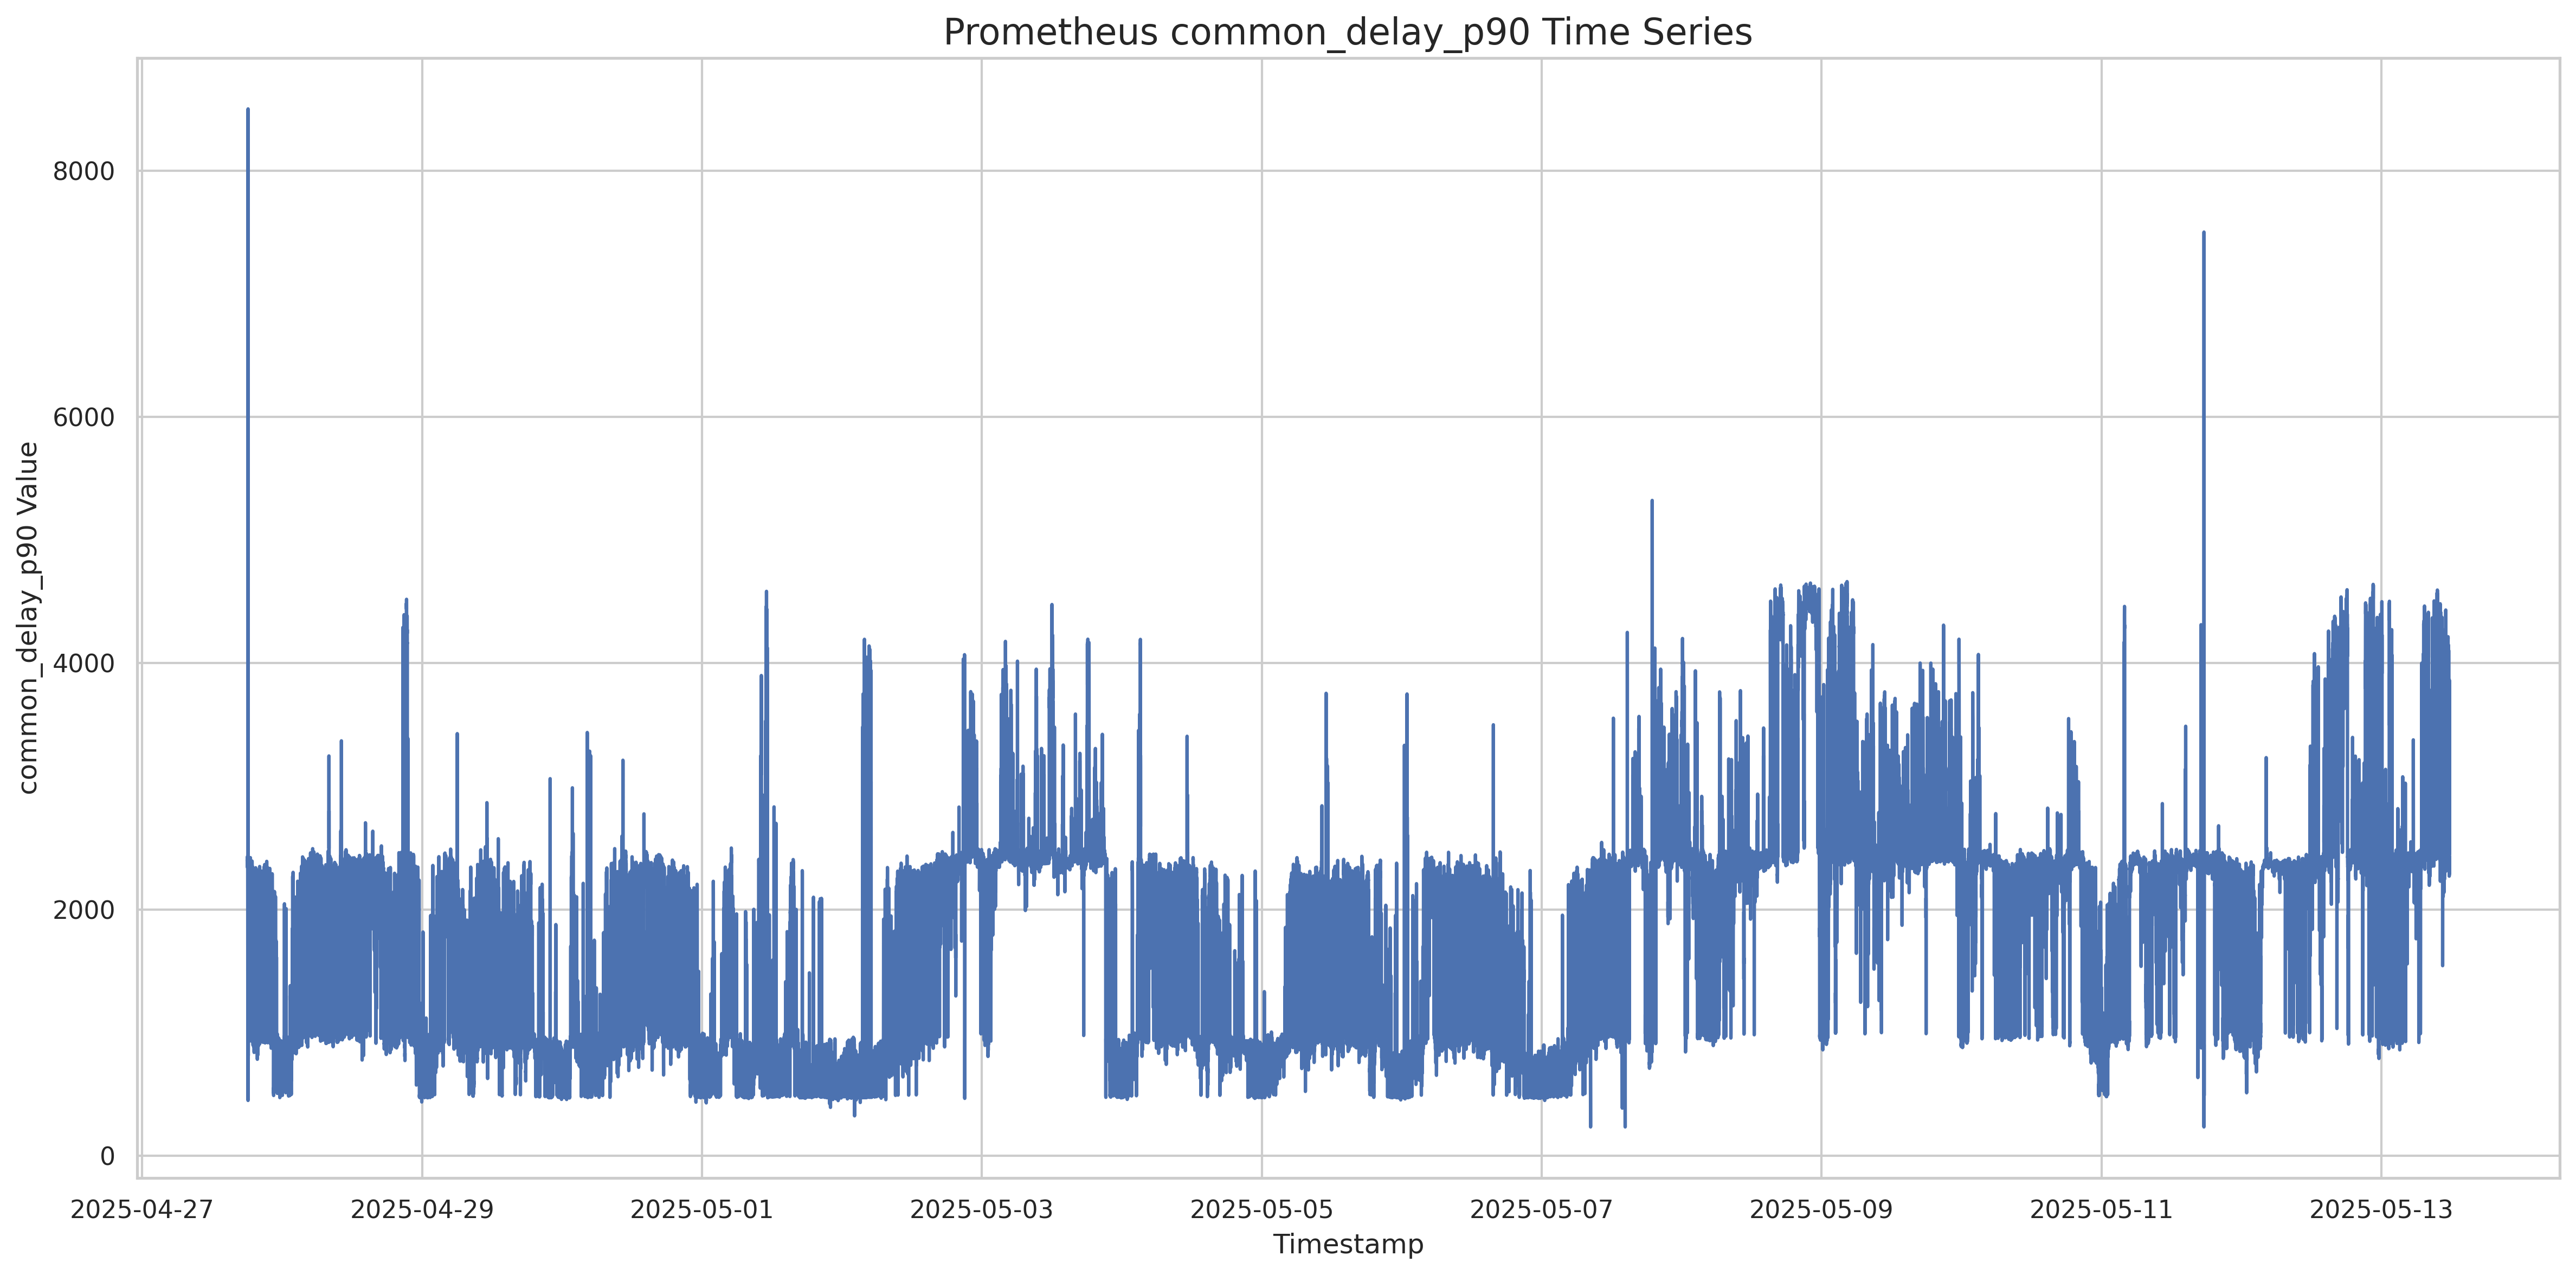

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.dpi'] = 300

# Set plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# Plot the common_delay_p90 series
sns.lineplot(data=df['common_delay_p90'])
plt.title('Prometheus common_delay_p90 Time Series', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('common_delay_p90 Value', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1 hour resampled data

/tmp/ipykernel_315353/2529452834.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')


Hourly resampled data info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 378 entries, 2025-04-27 18:00:00 to 2025-05-13 11:00:00
Freq: h
Series name: common_delay_p90
Non-Null Count  Dtype  
--------------  -----  
378 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB

Missing values after resampling:
0


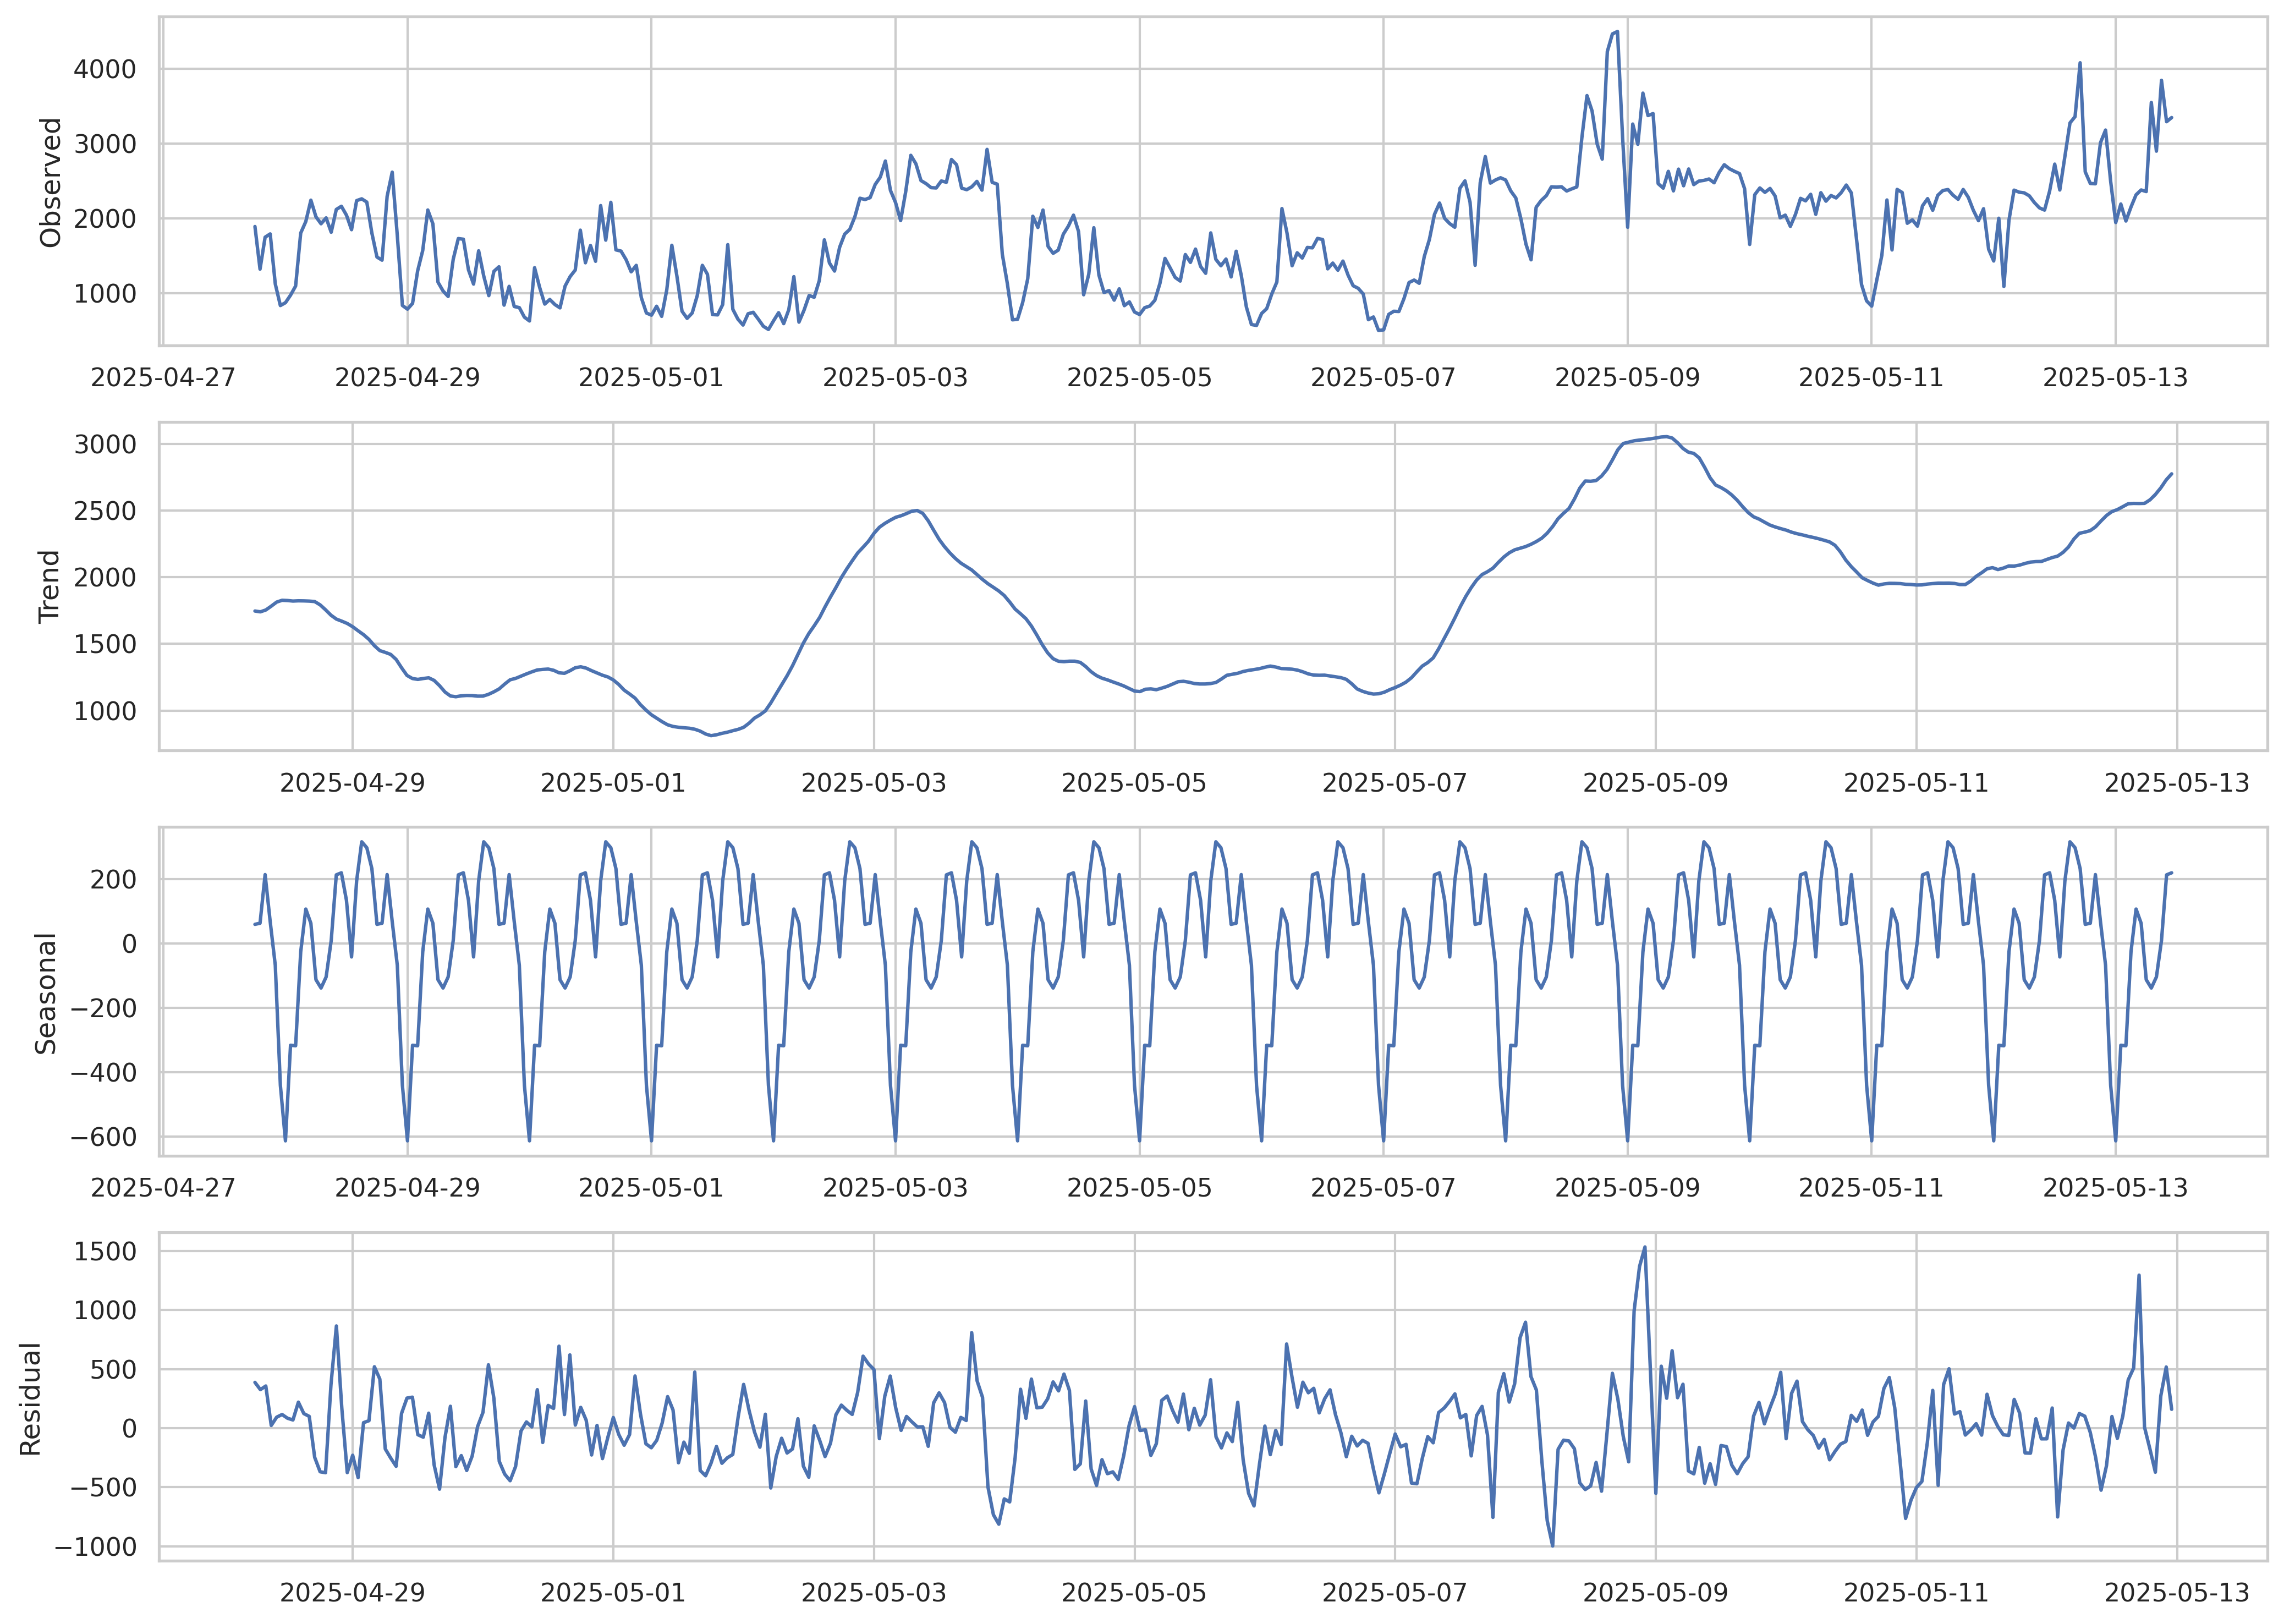

In [5]:

# Resample the data to an hourly frequency for easier analysis
df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')

print("Hourly resampled data info:")
df_hourly.info()
print("\nMissing values after resampling:")
print(df_hourly.isnull().sum())

# Perform seasonal decomposition (assuming daily seasonality for hourly data)
# Period for daily seasonality with hourly data is 24
decomposition = seasonal_decompose(df_hourly, model='additive', period=24)

# Plot decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

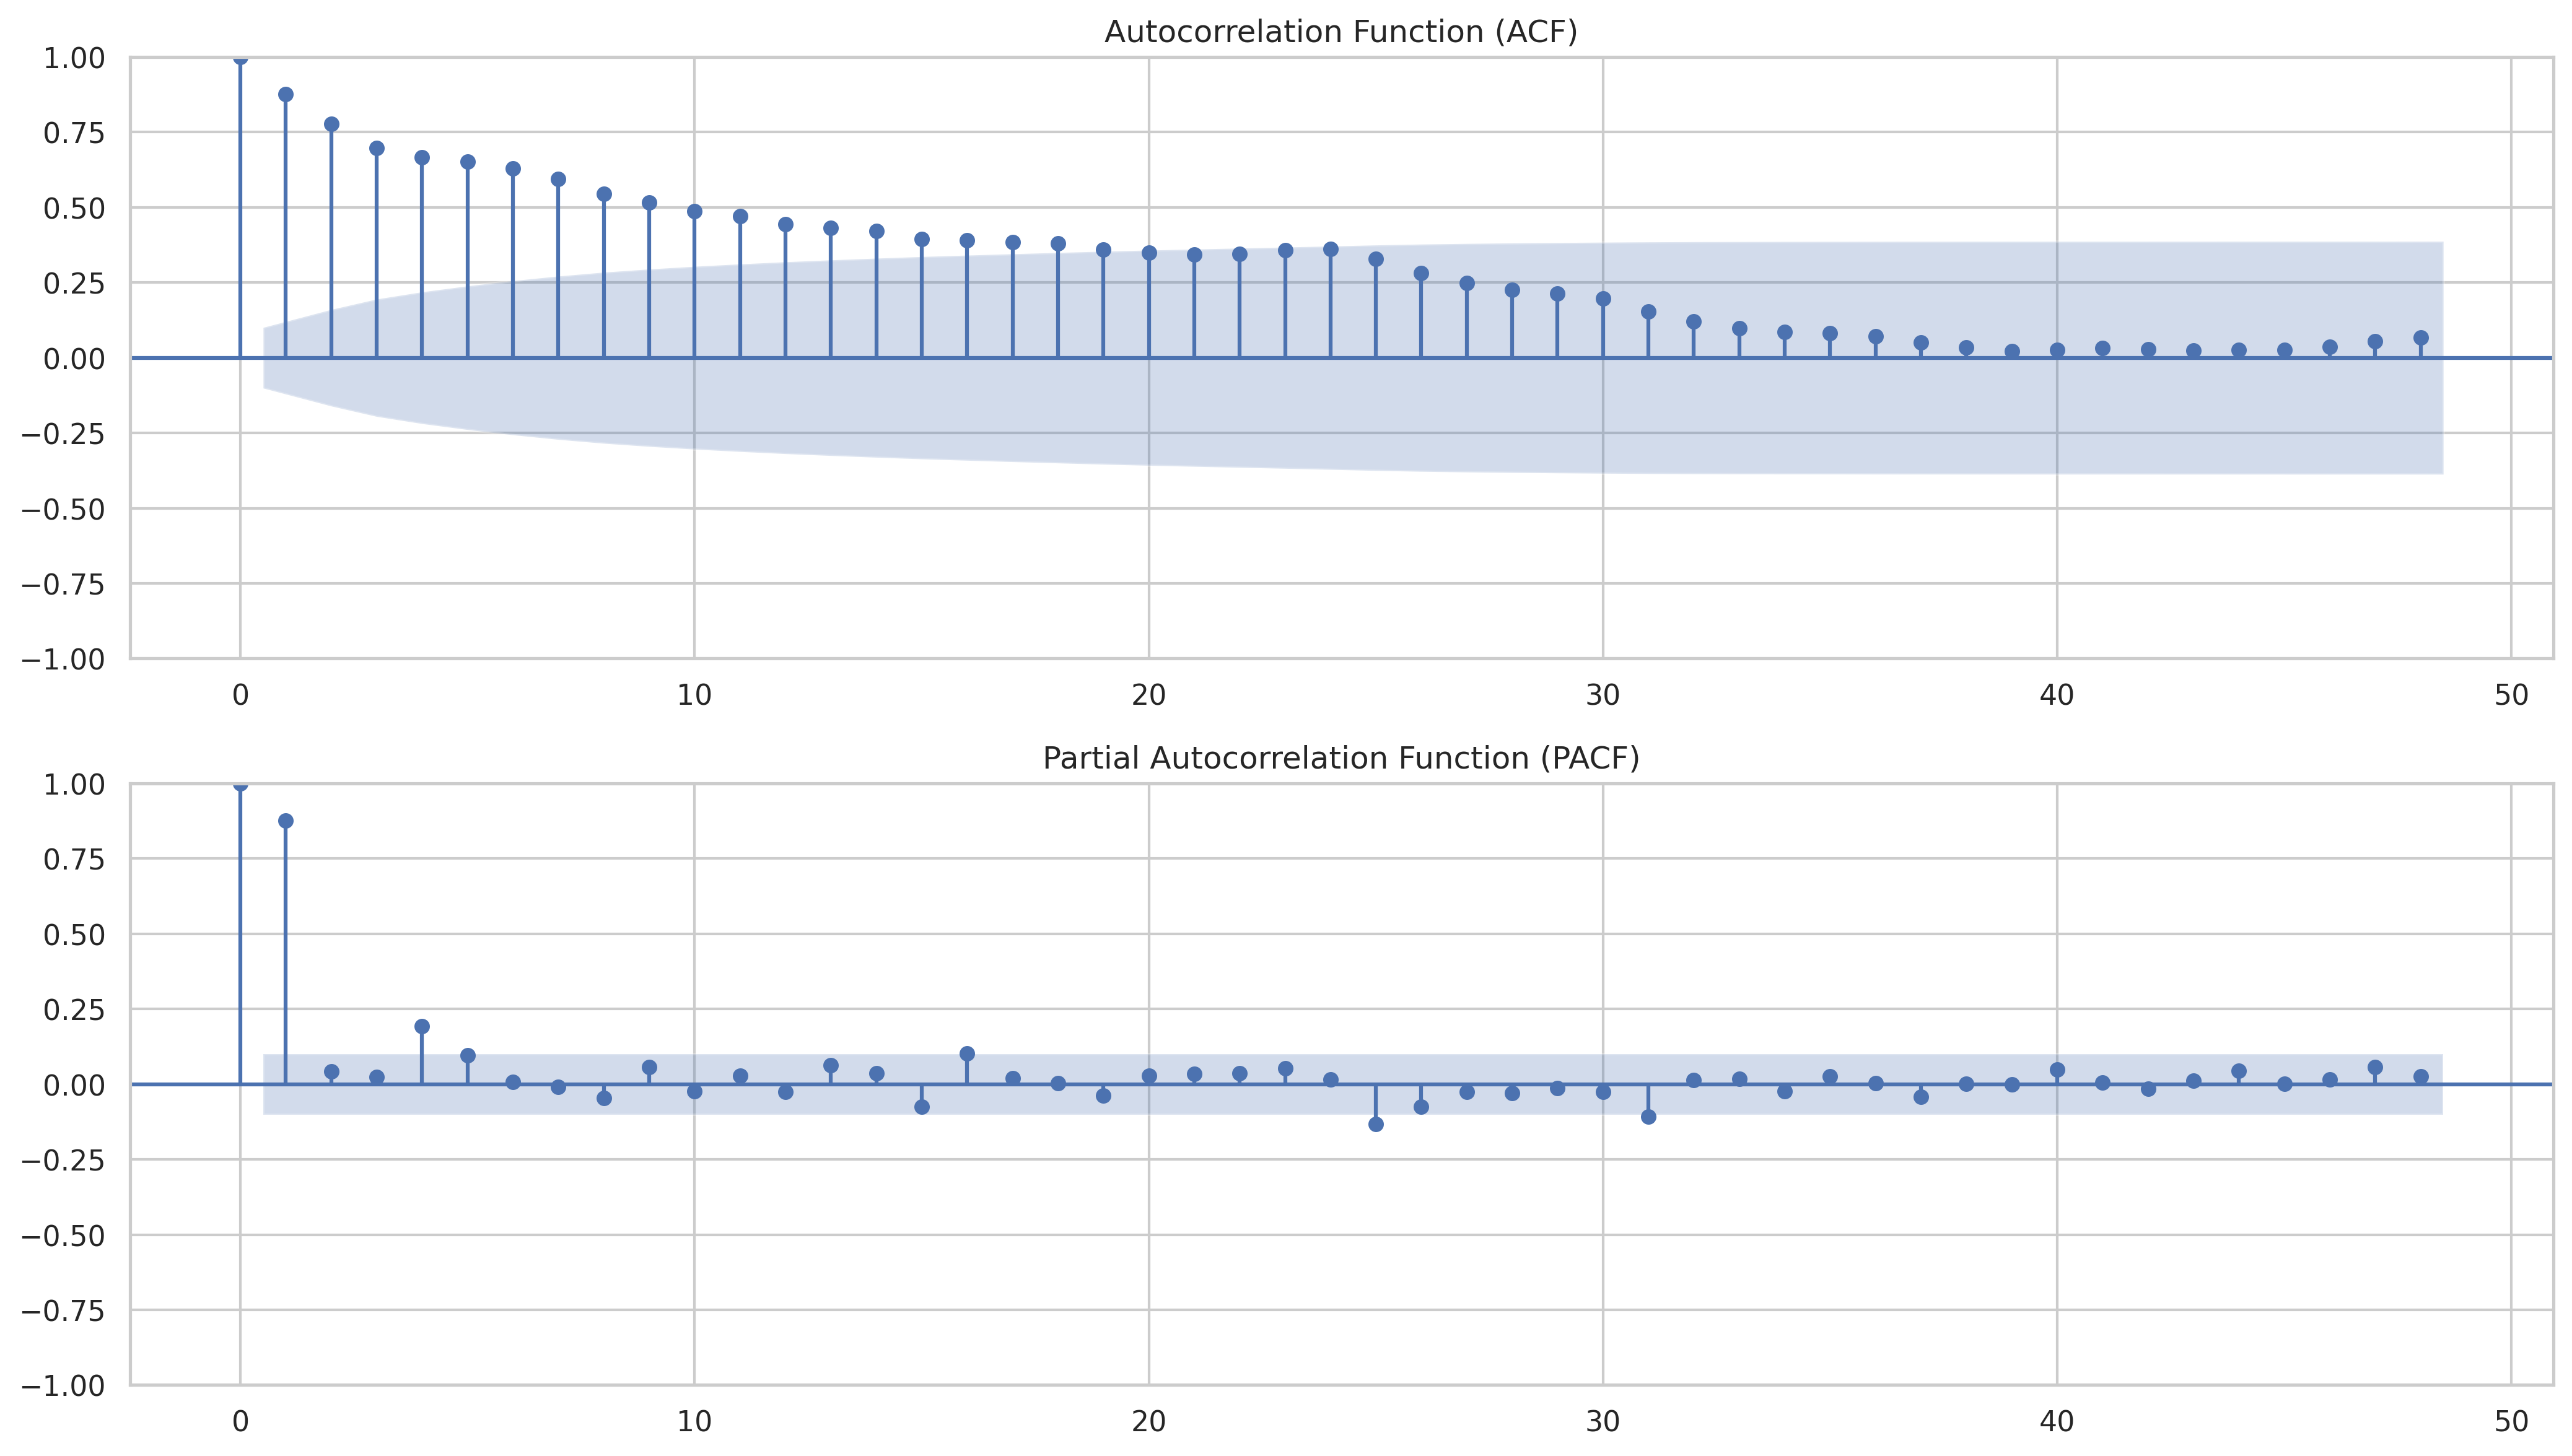

In [6]:
# Plot ACF and PACF to identify potential AR/MA components and seasonality
plt.figure(figsize=(14, 8))
plt.subplot(211)
plot_acf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

## Анализ исходного временного ряда (без ресемплинга)

Анализируем оригинальные данные с интервалом 15 секунд - как есть.


In [7]:

# Базовая информация об исходном ряде
print("=== Информация о исходном временном ряде ===")
print(f"Общее количество точек: {len(df)}")
print(f"Период данных: {df.index.min()} - {df.index.max()}")
print(f"Временной интервал между точками: {df.index.to_series().diff().mode()[0]}")
print(f"Пропущенные значения: {df['common_delay_p90'].isnull().sum()}")

# Базовая статистика
print("\n=== Основная статистика ===")
print(df['common_delay_p90'].describe())

# Проверим частоту данных
time_diffs = df.index.to_series().diff().dropna()
print(f"\nЧастота данных:")
print(f"Медианный интервал: {time_diffs.median()}")
print(f"Минимальный интервал: {time_diffs.min()}")
print(f"Максимальный интервал: {time_diffs.max()}")
print(f"Стандартное отклонение интервалов: {time_diffs.std()}")


print("\nПроверка на дубликаты во временном индексе:")
print(f"Количество дубликатов в индексе: {df.index.duplicated().sum()}")
if df.index.duplicated().any():
    print("Внимание: Обнаружены дубликаты во временном индексе. Обрабатываю...")
    # Удаляем дубликаты, оставляя последнее значение, или усредняем
    df = df.loc[~df.index.duplicated(keep='last')] # или .mean() если усреднение
    # df = df.resample('15S').mean() # Альтернативный способ, если нужны все 15s интервалы, даже пропущенные
    print(f"Количество точек после обработки дубликатов: {len(df)}")


=== Информация о исходном временном ряде ===
Общее количество точек: 90643
Период данных: 2025-04-27 18:00:30 - 2025-05-13 11:41:00
Временной интервал между точками: 0 days 00:00:15
Пропущенные значения: 2

=== Основная статистика ===
count    90641.000000
mean      1802.349510
std        901.617551
min        235.000000
25%        922.395833
50%       2094.852941
75%       2382.755633
max       8500.000000
Name: common_delay_p90, dtype: float64

Частота данных:
Медианный интервал: 0 days 00:00:15
Минимальный интервал: 0 days 00:00:15
Максимальный интервал: 0 days 00:00:15
Стандартное отклонение интервалов: 0 days 00:00:00

Проверка на дубликаты во временном индексе:
Количество дубликатов в индексе: 0


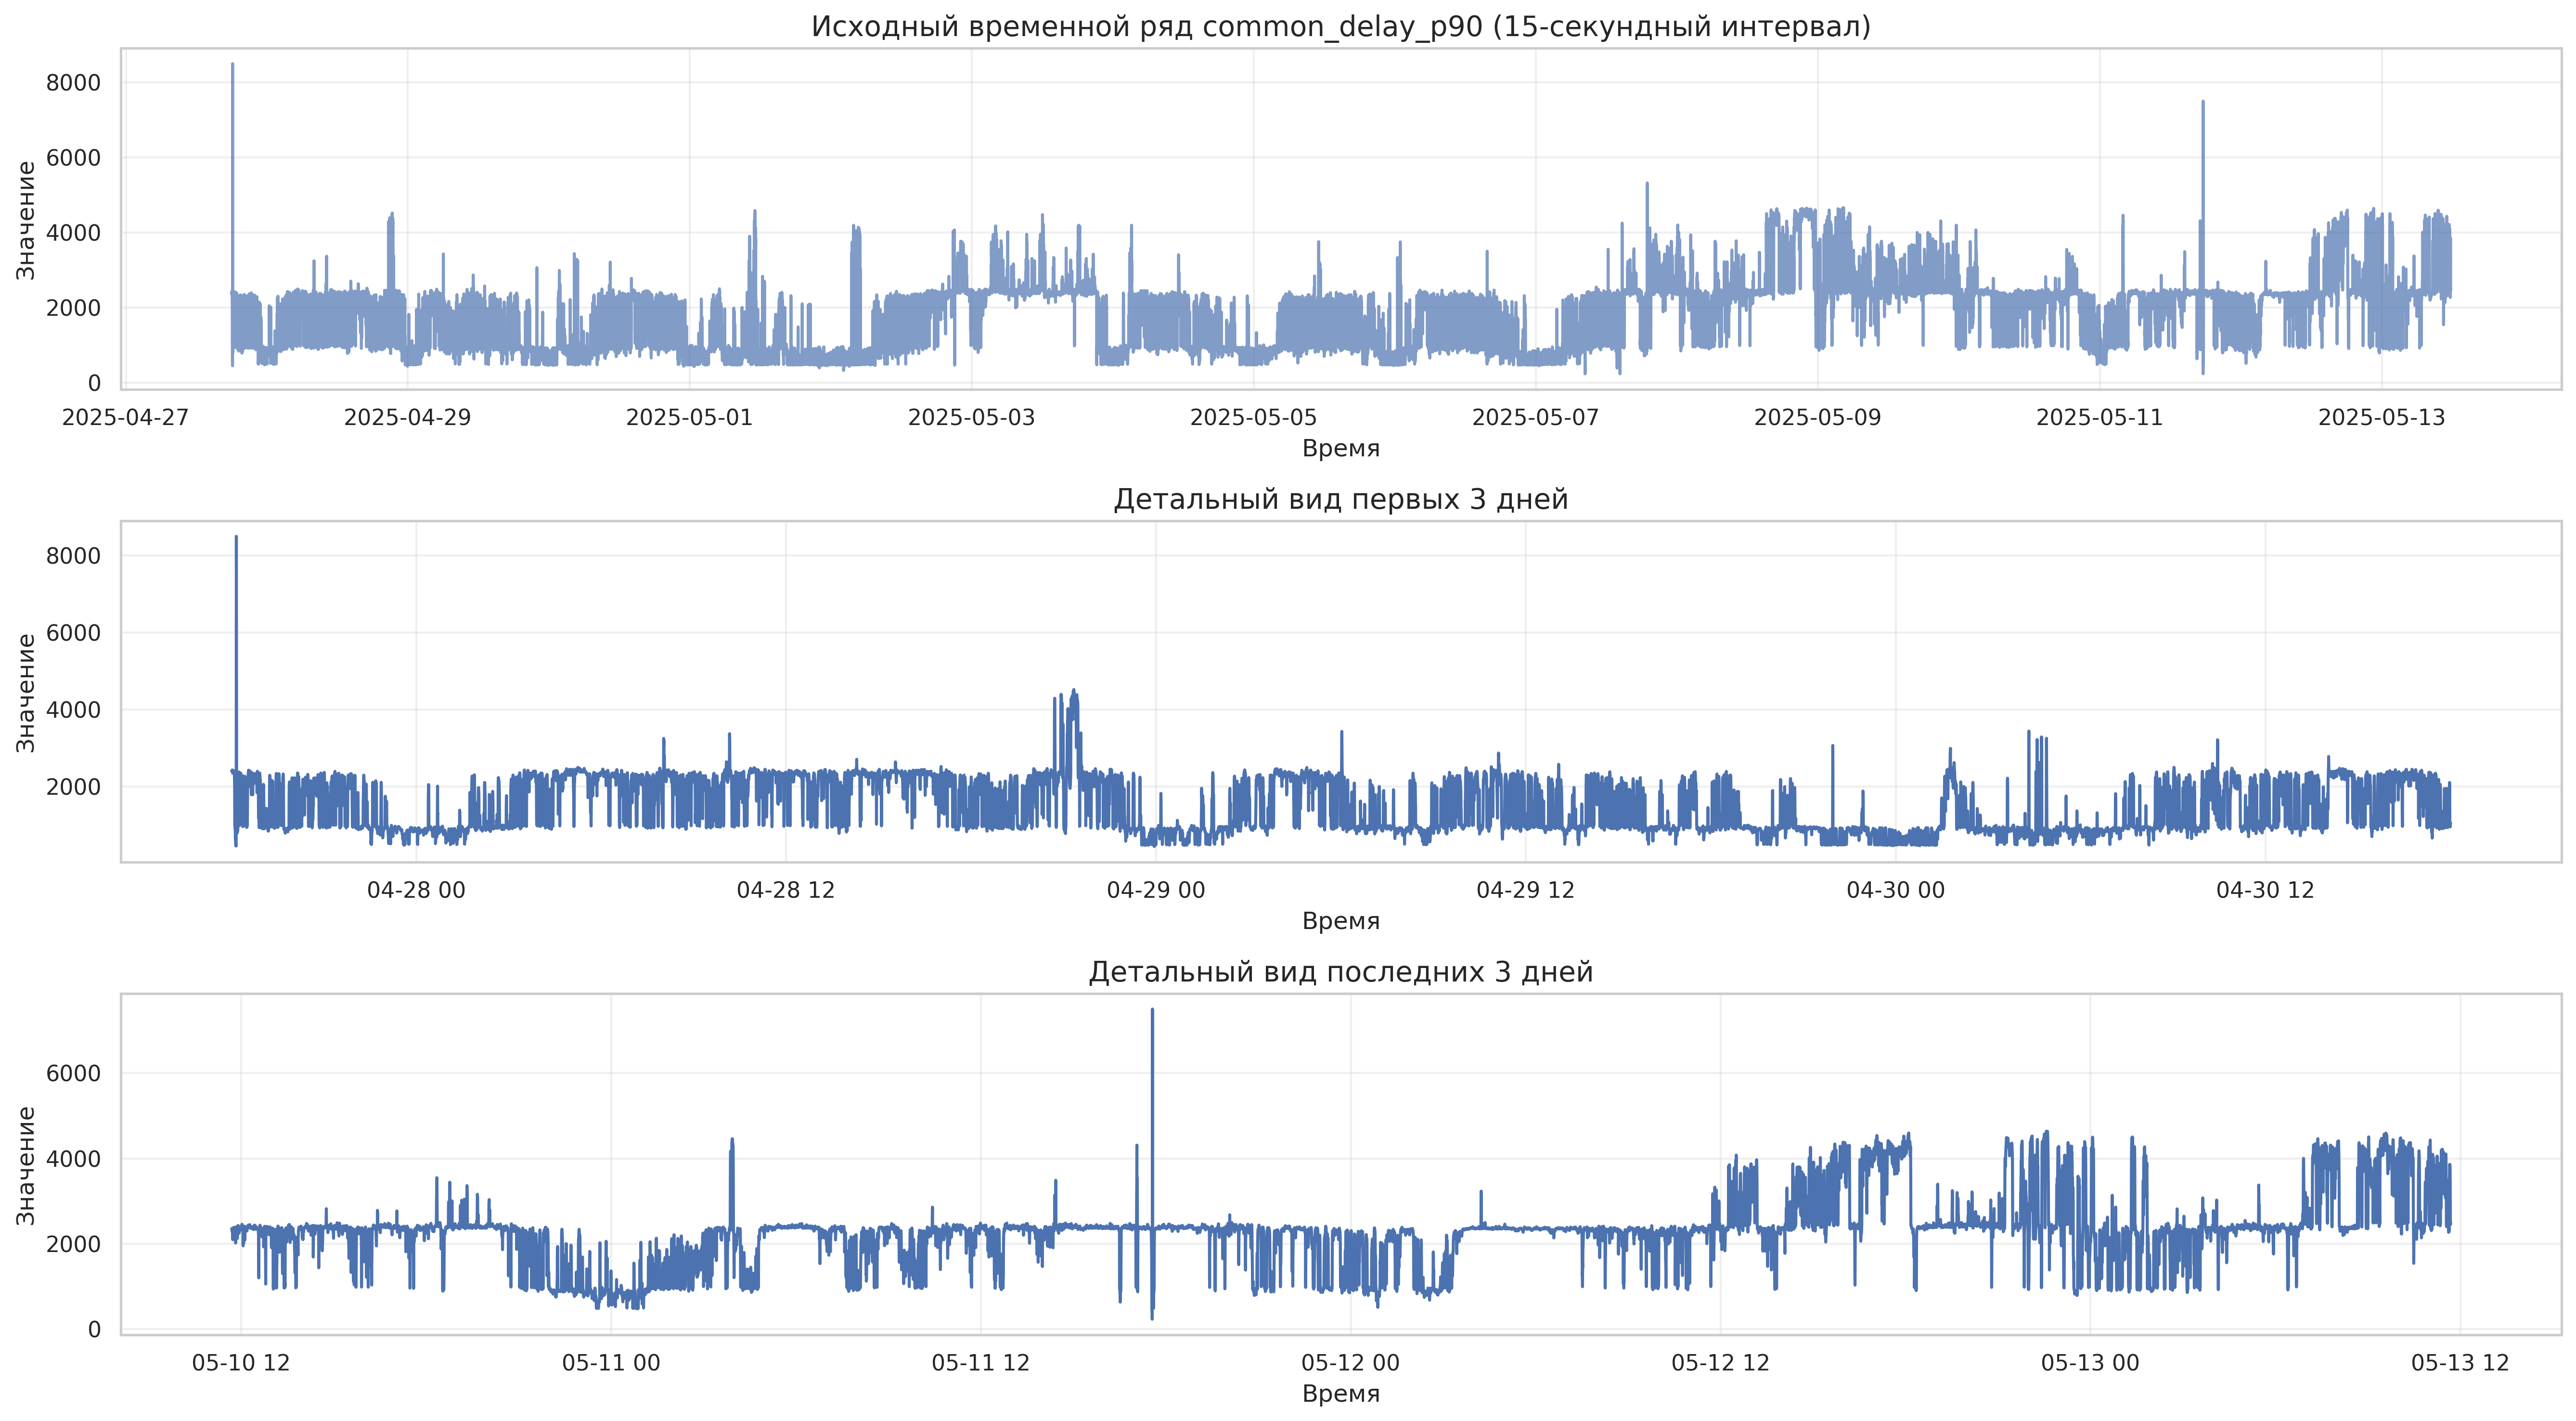

In [8]:
# Визуализация оригинального временного ряда
plt.figure(figsize=(18, 10))

# 1. Полный ряд
plt.subplot(3, 1, 1)
sns.lineplot(data=df, x=df.index, y='common_delay_p90', alpha=0.7)
plt.title('Исходный временной ряд common_delay_p90 (15-секундный интервал)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

# 2. Приближение на первые 3 дня
plt.subplot(3, 1, 2)
first_3_days = df.head(17280)  # примерно 3 дня * 24 часа * 240 точек в час
sns.lineplot(data=first_3_days, x=first_3_days.index, y='common_delay_p90')
plt.title('Детальный вид первых 3 дней', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

# 3. Последние 3 дня
plt.subplot(3, 1, 3)
last_3_days = df.tail(17280)
sns.lineplot(data=last_3_days, x=last_3_days.index, y='common_delay_p90')
plt.title('Детальный вид последних 3 дней', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Используется подвыборка: усреднение до 1-минутного интервала
Размер выборки: 22662 точек
Период для сезонной декомпозиции: 1440


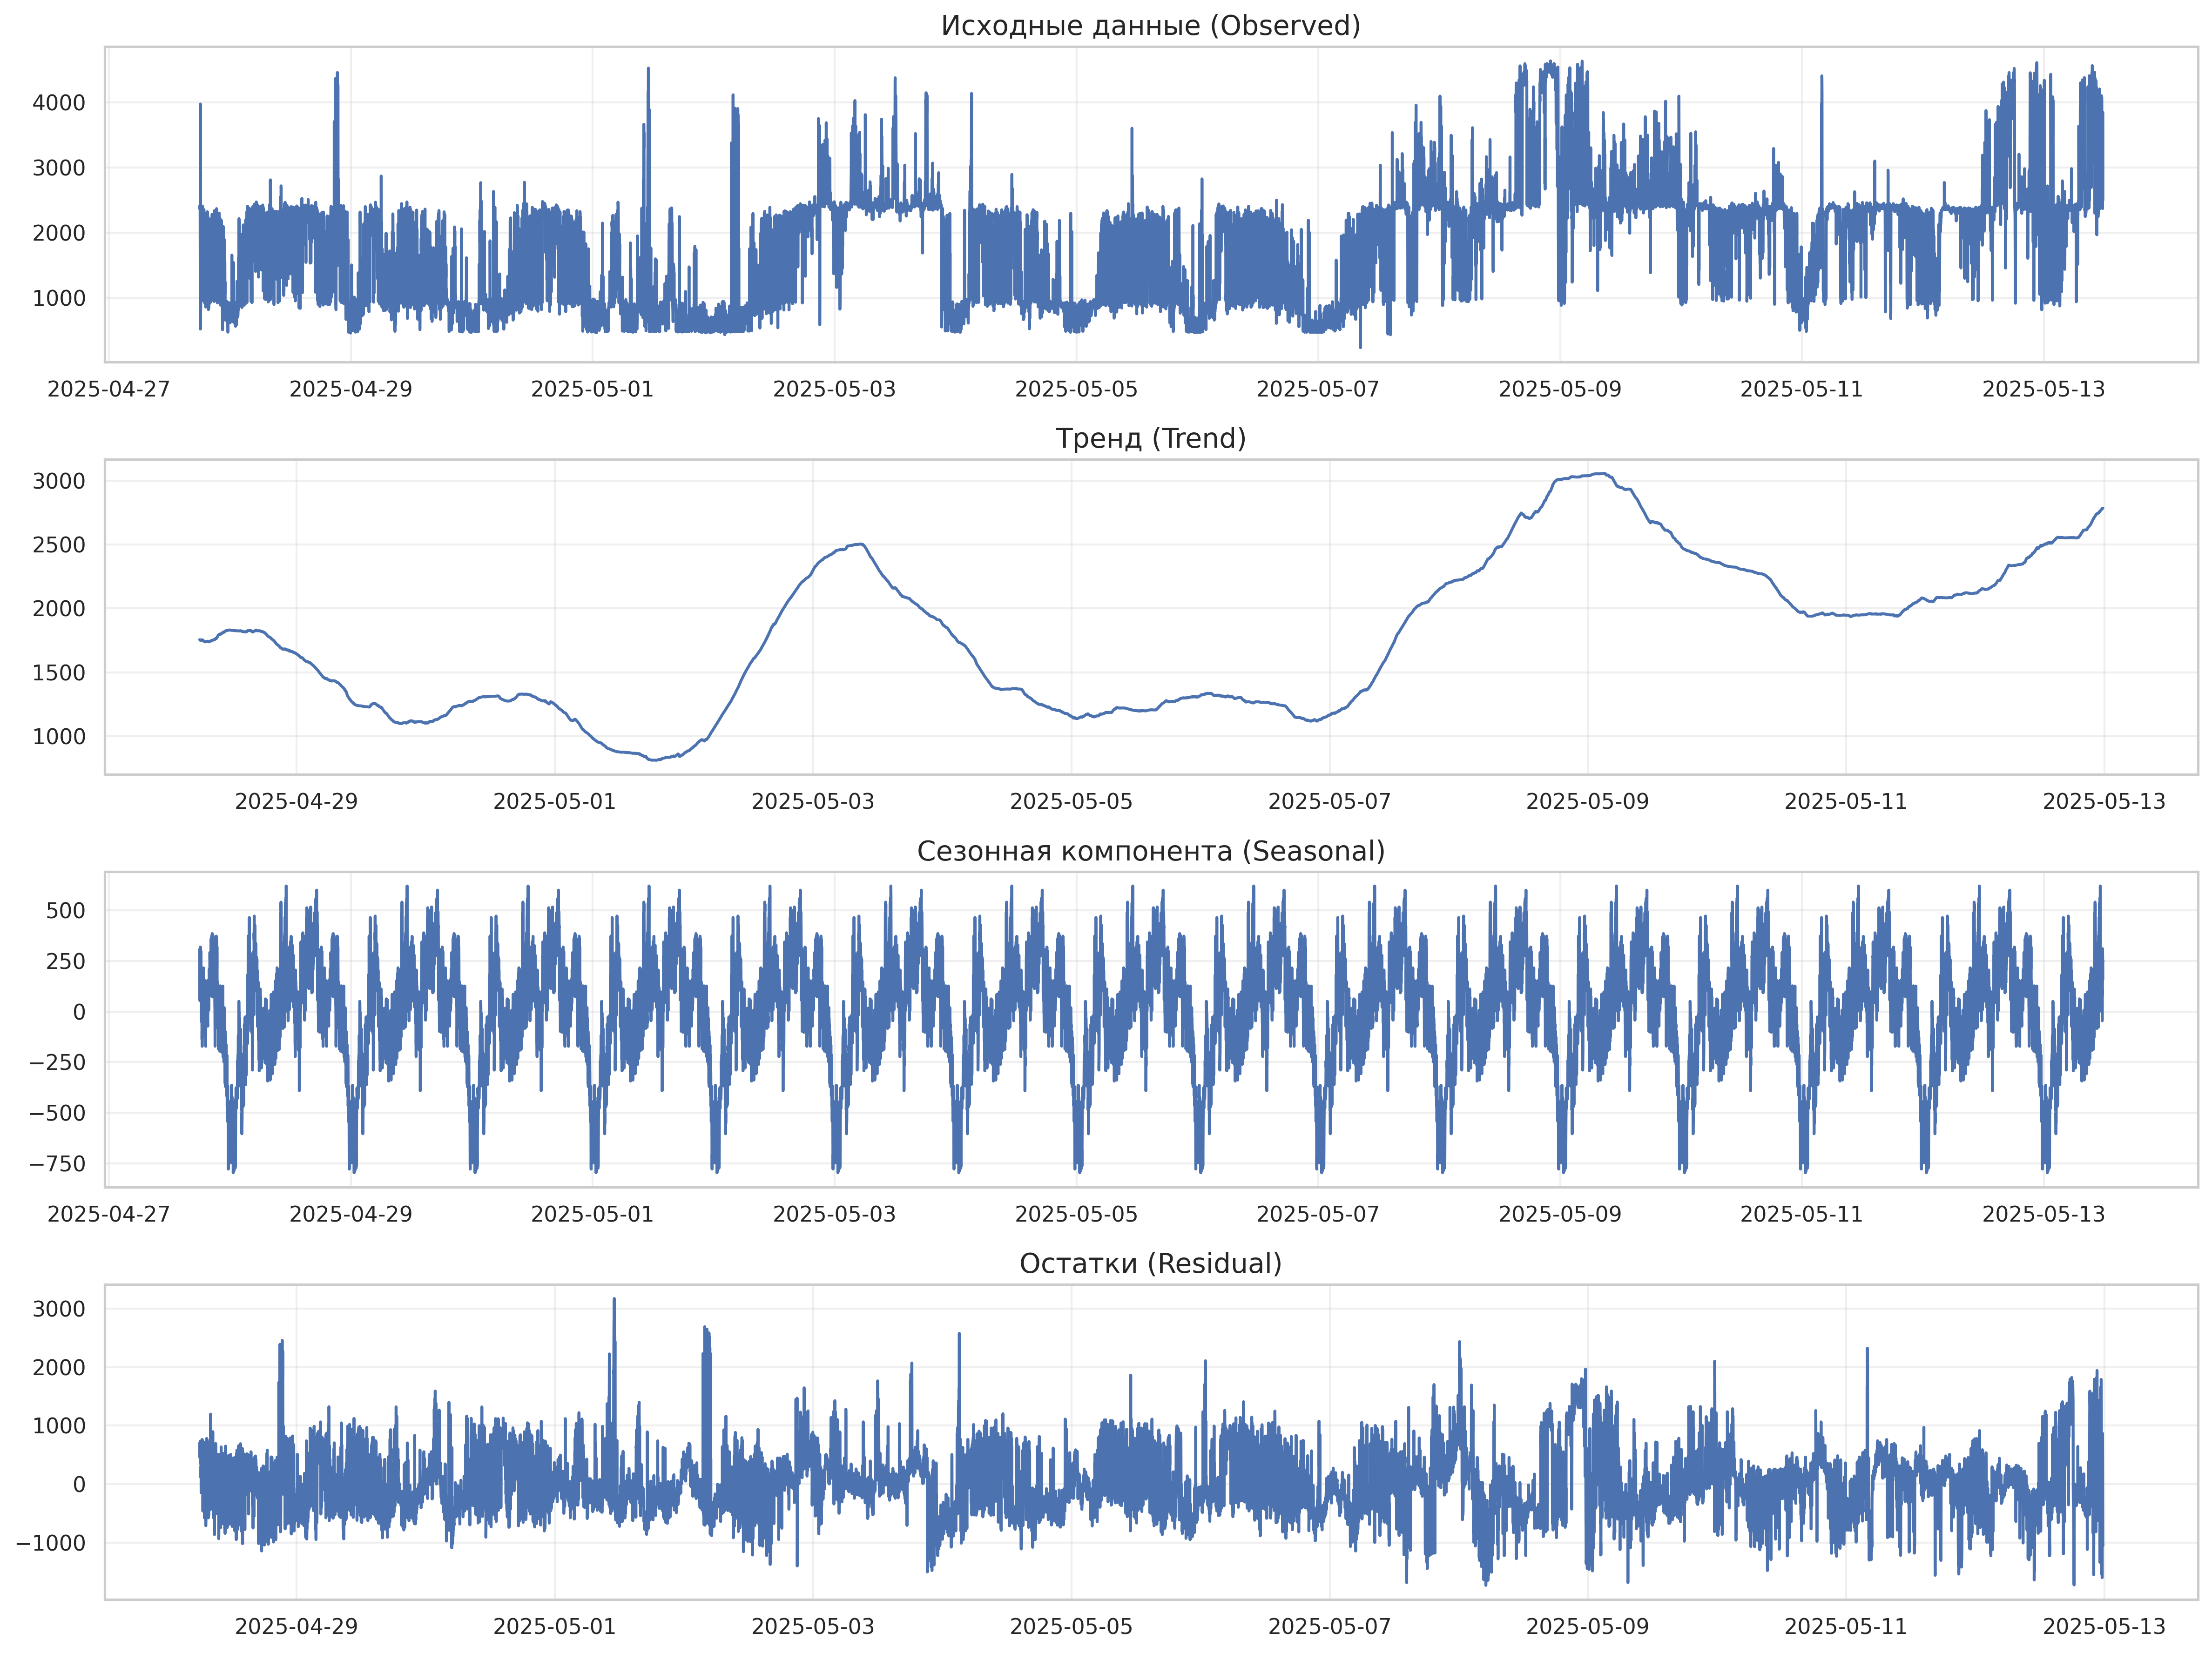

In [9]:
# Сезонная декомпозиция на исходных данных
# Для данных с интервалом 15 секунд:
# - В одном часе: 240 точек (3600 сек / 15 сек)
# - В одном дне: 5760 точек (24 * 240)

# Возьмем подвыборку для декомпозиции (слишком много данных для полного анализа)
# Возьмем данные за 7 дней для анализа недельной сезонности
week_data = df['common_delay_p90'].dropna()

# Если данных слишком много, усредним до 1-минутного интервала
if len(week_data) > 50000:
    # Усредняем каждые 4 точки для получения 1-минутных данных
    week_data_sample = week_data.resample('1min').mean()
    print(f"Используется подвыборка: усреднение до 1-минутного интервала")
    print(f"Размер выборки: {len(week_data_sample)} точек")
    period = 1440  # 24 часа * 60 минут = дневная сезонность
else:
    week_data_sample = week_data
    period = 5760  # дневная сезонность для 15-секундных данных

print(f"Период для сезонной декомпозиции: {period}")

# Сезонная декомпозиция
decomposition = seasonal_decompose(week_data_sample, model='additive', period=period)

# Визуализация декомпозиции
plt.figure(figsize=(16, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Исходные данные (Observed)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Тренд (Trend)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Сезонная компонента (Seasonal)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Остатки (Residual)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


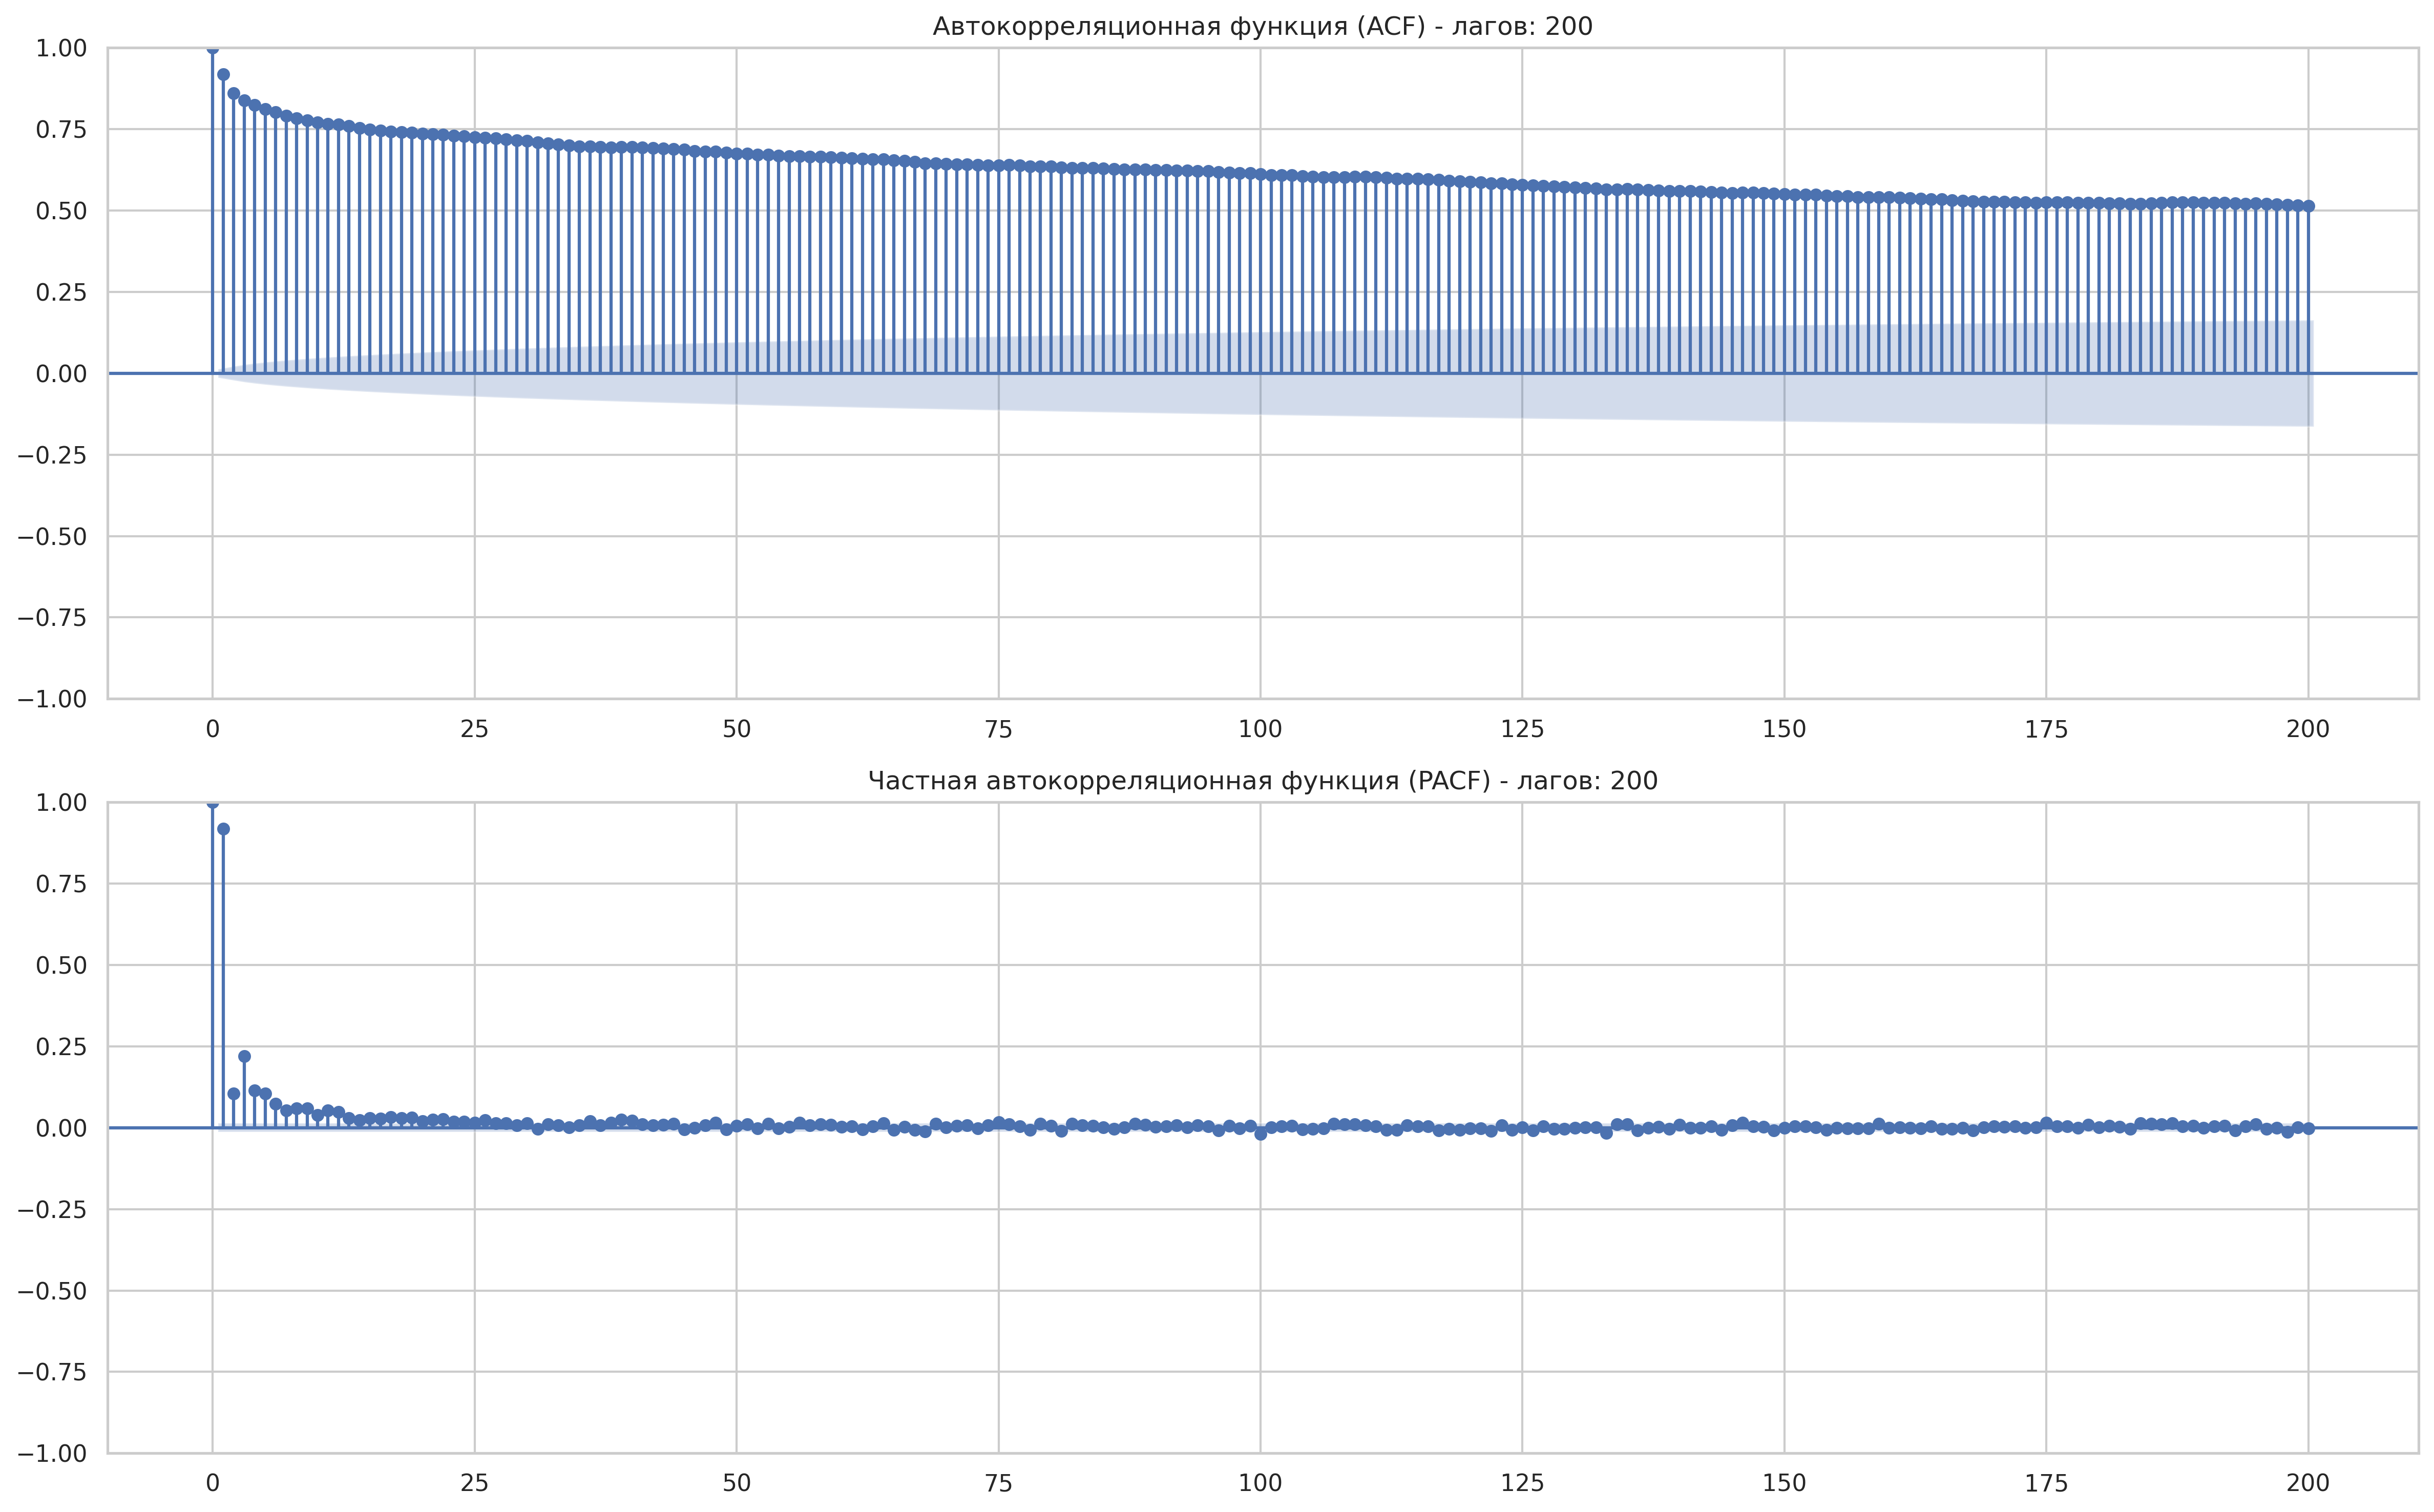

Анализ корреляций для 22662 точек данных
Максимальный лаг: 200 (примерно 3.3 часов для 1-минутных данных)


In [10]:
# ACF/PACF анализ для исходных данных
# Возьмем подвыборку для корреляционного анализа
sample_for_acf = week_data_sample.dropna()

# Лагов на 2 дня (для 1-минутных данных: 2880 точек, но ограничим до 200 для читаемости)
max_lags = min(200, len(sample_for_acf) // 4)

plt.figure(figsize=(16, 10))

# ACF
plt.subplot(2, 1, 1)
plot_acf(sample_for_acf, lags=max_lags, ax=plt.gca(), 
         title=f'Автокорреляционная функция (ACF) - лагов: {max_lags}')

# PACF
plt.subplot(2, 1, 2)
plot_pacf(sample_for_acf, lags=max_lags, ax=plt.gca(), 
          title=f'Частная автокорреляционная функция (PACF) - лагов: {max_lags}')

plt.tight_layout()
plt.show()

print(f"Анализ корреляций для {len(sample_for_acf)} точек данных")
print(f"Максимальный лаг: {max_lags} (примерно {max_lags/60:.1f} часов для 1-минутных данных)")


In [11]:
# Дополнительный статистический анализ
import numpy as np
from scipy import stats

raw_data = df['common_delay_p90'].dropna()

print("=== Расширенный статистический анализ ===")
print(f"Количество наблюдений: {len(raw_data)}")
print(f"Среднее: {raw_data.mean():.3f}")
print(f"Медиана: {raw_data.median():.3f}")
print(f"Стандартное отклонение: {raw_data.std():.3f}")
print(f"Коэффициент вариации: {(raw_data.std()/raw_data.mean())*100:.2f}%")
print(f"Асимметрия (skewness): {stats.skew(raw_data):.3f}")
print(f"Эксцесс (kurtosis): {stats.kurtosis(raw_data):.3f}")

# Процентили
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"\nПроцентили:")
for p in percentiles:
    value = np.percentile(raw_data, p)
    print(f"P{p}: {value:.3f}")

# Тест на нормальность
shapiro_stat, shapiro_p = stats.shapiro(raw_data[:5000])  # ограничиваем размер для теста
print(f"\nТест Шапиро-Уилка на нормальность (первые 5000 точек):")
print(f"Статистика: {shapiro_stat:.6f}, p-value: {shapiro_p:.6f}")
print(f"Данные {'НЕ ' if shapiro_p < 0.05 else ''}распределены нормально (α=0.05)")


=== Расширенный статистический анализ ===
Количество наблюдений: 90641
Среднее: 1802.350
Медиана: 2094.853
Стандартное отклонение: 901.618
Коэффициент вариации: 50.02%
Асимметрия (skewness): 0.476
Эксцесс (kurtosis): 0.076

Процентили:
P1: 475.000
P5: 497.857
P10: 764.286
P25: 922.396
P50: 2094.853
P75: 2382.756
P90: 2477.913
P95: 3364.286
P99: 4402.445

Тест Шапиро-Уилка на нормальность (первые 5000 точек):
Статистика: 0.831212, p-value: 0.000000
Данные НЕ распределены нормально (α=0.05)


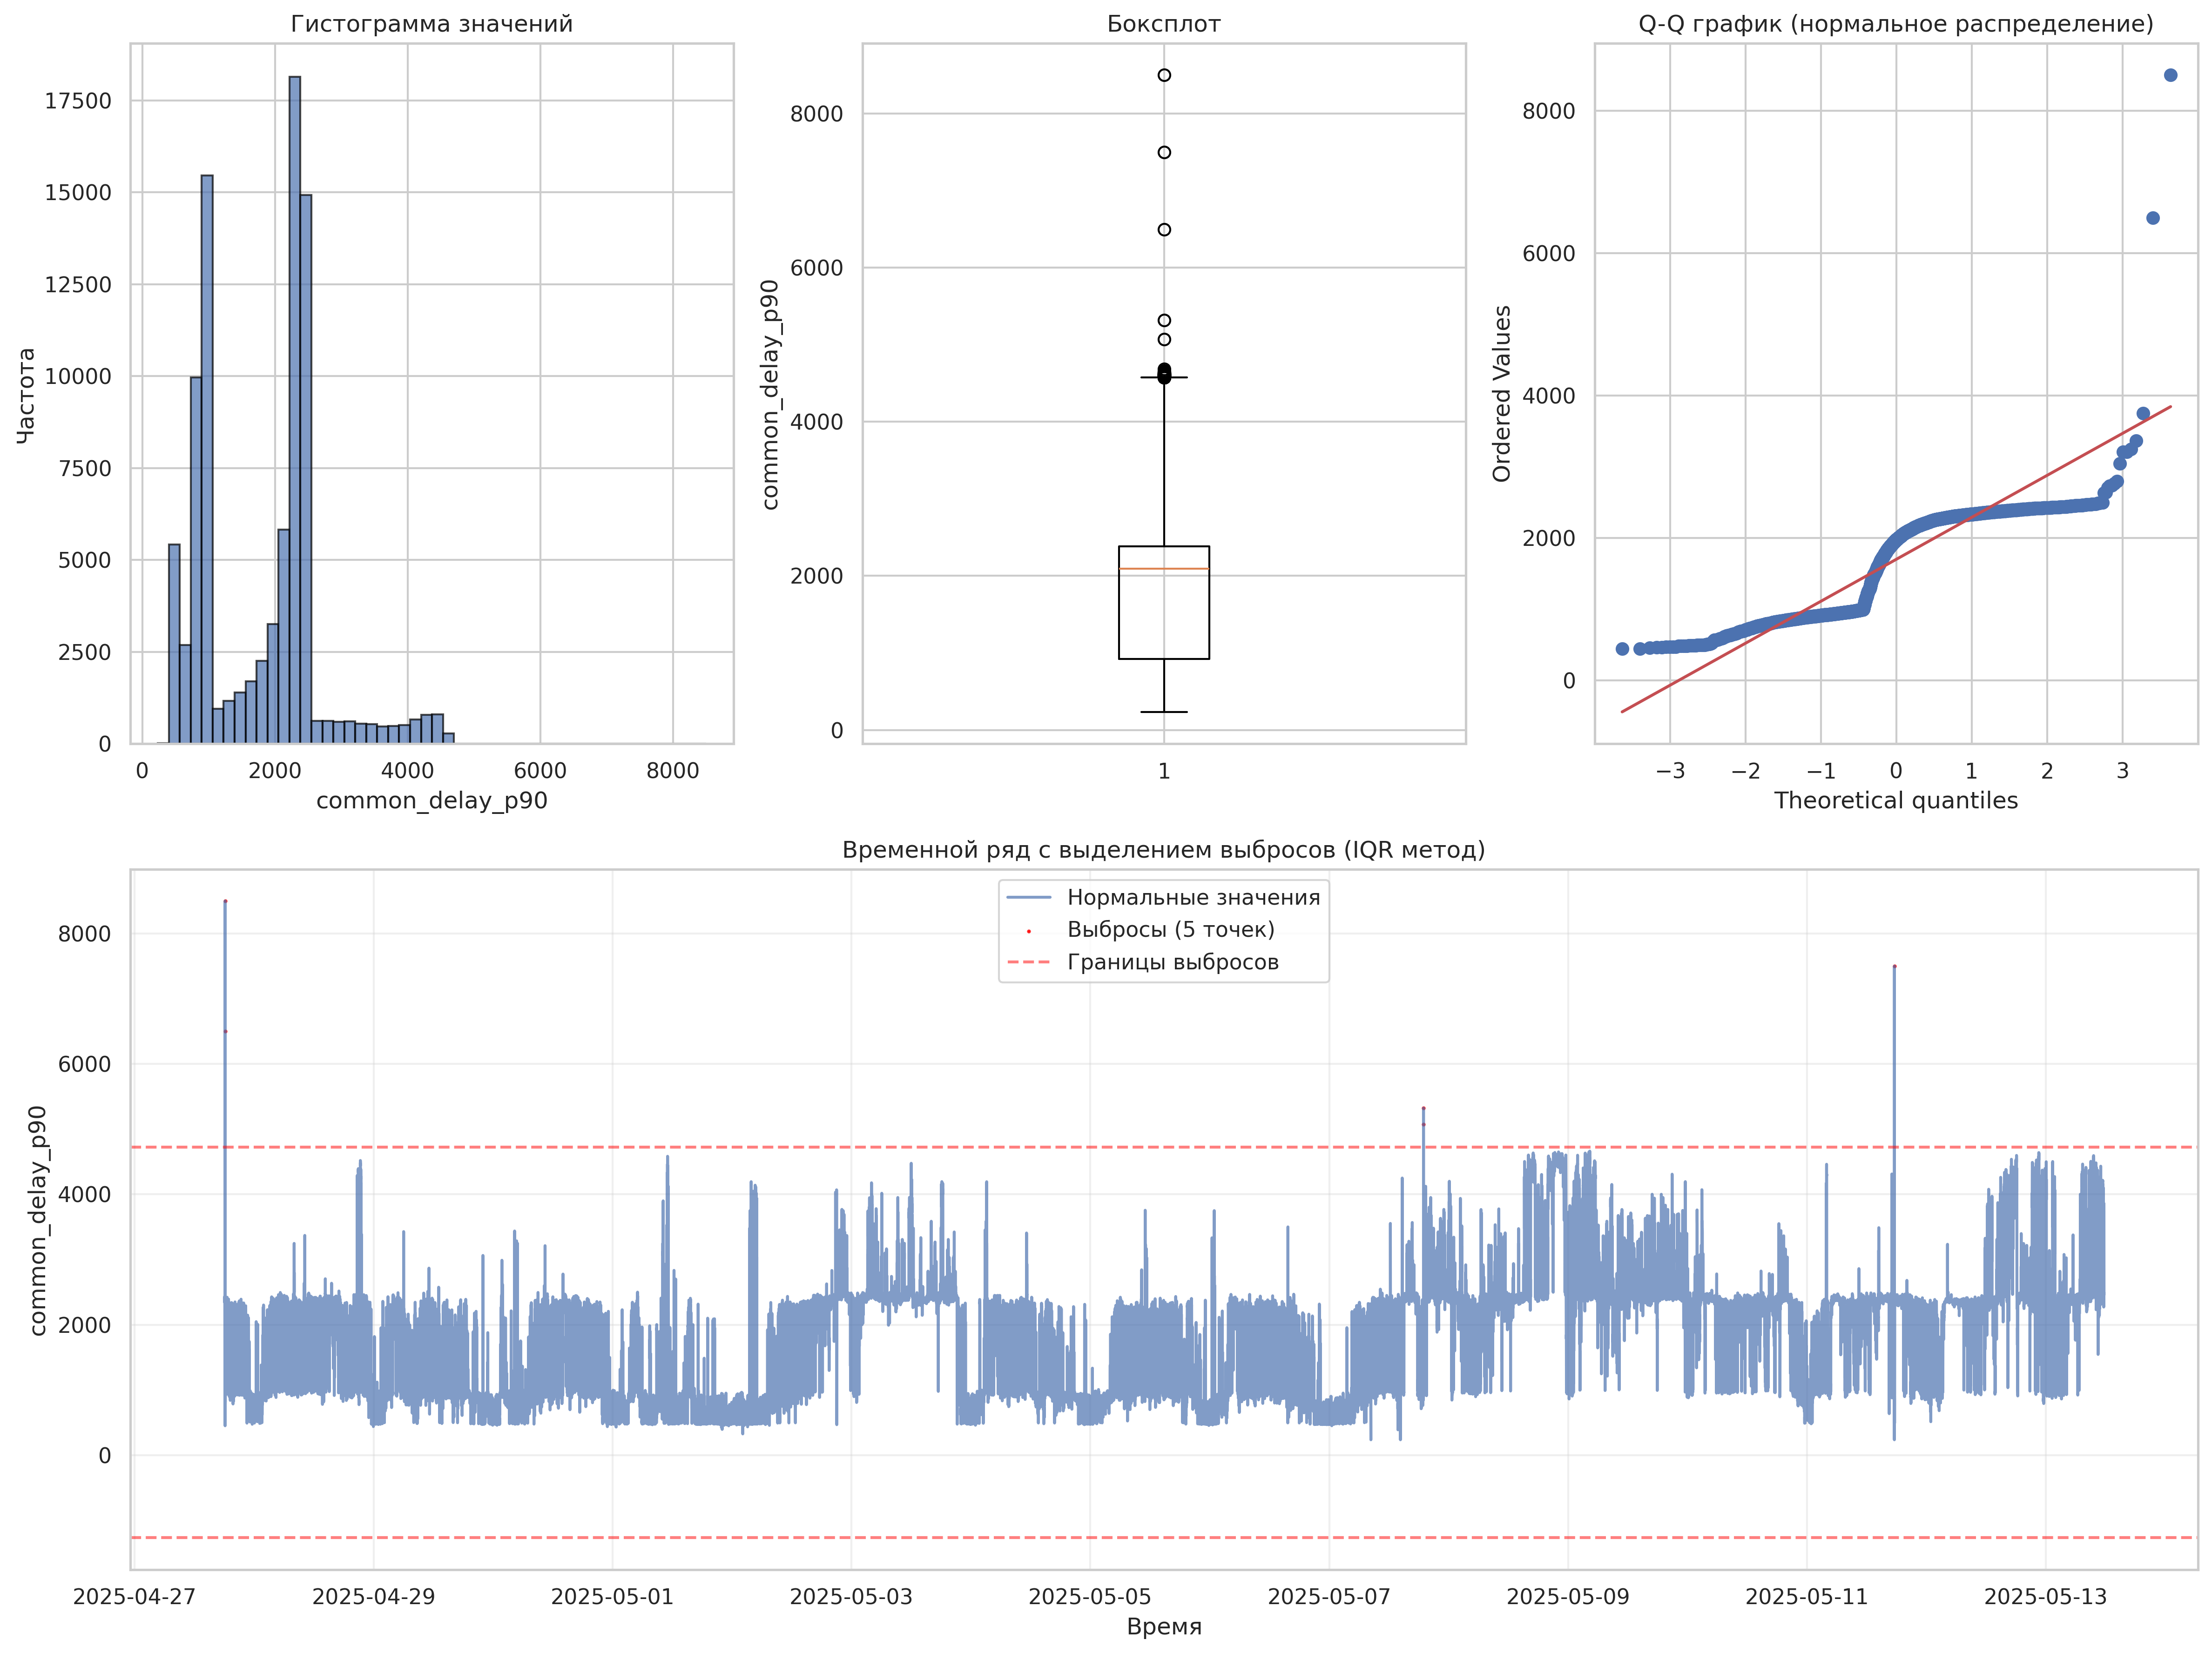

Выбросы (IQR метод):
Нижняя граница: -1268.144
Верхняя граница: 4723.295
Количество выбросов: 5 (0.01%)
Минимальный выброс: 5071.429
Максимальный выброс: 8500.000


In [18]:
# Распределение значений и выбросы
plt.figure(figsize=(16, 12))

# 1. Гистограмма
plt.subplot(2, 3, 1)
plt.hist(raw_data, bins=50, alpha=0.7, edgecolor='black')
plt.title('Гистограмма значений', fontsize=12)
plt.xlabel('common_delay_p90')
plt.ylabel('Частота')

# 2. Boxplot
plt.subplot(2, 3, 2)
plt.boxplot(raw_data)
plt.title('Боксплот', fontsize=12)
plt.ylabel('common_delay_p90')

# 3. Q-Q plot
plt.subplot(2, 3, 3)
stats.probplot(raw_data[:5000], dist="norm", plot=plt)
plt.title('Q-Q график (нормальное распределение)', fontsize=12)

# 4. Временной ряд с выделением выбросов
plt.subplot(2, 1, 2)
Q1 = raw_data.quantile(0.25)
Q3 = raw_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR + 150

outliers = raw_data[(raw_data < lower_bound) | (raw_data > upper_bound)]

plt.plot(raw_data.index, raw_data, alpha=0.7, label='Нормальные значения')
plt.scatter(outliers.index, outliers, color='red', alpha=0.8, s=1, label=f'Выбросы ({len(outliers)} точек)')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5, label=f'Границы выбросов')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Временной ряд с выделением выбросов (IQR метод)', fontsize=12)
plt.xlabel('Время')
plt.ylabel('common_delay_p90')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Выбросы (IQR метод):")
print(f"Нижняя граница: {lower_bound:.3f}")
print(f"Верхняя граница: {upper_bound:.3f}")
print(f"Количество выбросов: {len(outliers)} ({len(outliers)/len(raw_data)*100:.2f}%)")
print(f"Минимальный выброс: {outliers.min():.3f}")
print(f"Максимальный выброс: {outliers.max():.3f}")


In [13]:
# Анализ стационарности временного ряда
from statsmodels.tsa.stattools import adfuller, kpss

print("=== Тесты на стационарность ===")

# Тест Дики-Фуллера (ADF)
adf_result = adfuller(raw_data.dropna())
print("Расширенный тест Дики-Фуллера (ADF):")
print(f"ADF статистика: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print("Критические значения:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.3f}")
print(f"Ряд {'стационарен' if adf_result[1] < 0.05 else 'НЕ стационарен'} (α=0.05)")

print("\n" + "="*50)

# Тест KPSS
kpss_result = kpss(raw_data.dropna(), regression='c')
print("Тест KPSS:")
print(f"KPSS статистика: {kpss_result[0]:.6f}")
print(f"p-value: {kpss_result[1]:.6f}")
print("Критические значения:")
for key, value in kpss_result[3].items():
    print(f"\t{key}: {value:.3f}")
print(f"Ряд {'стационарен' if kpss_result[1] > 0.05 else 'НЕ стационарен'} (α=0.05)")

print("\n" + "="*50)
print("Интерпретация:")
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("✅ Ряд СТАЦИОНАРЕН по обоим тестам")
elif adf_result[1] >= 0.05 and kpss_result[1] <= 0.05:
    print("❌ Ряд НЕ СТАЦИОНАРЕН по обоим тестам")
else:
    print("⚠️  Противоречивые результаты тестов - требуется дополнительный анализ")


=== Тесты на стационарность ===


Расширенный тест Дики-Фуллера (ADF):
ADF статистика: -9.590630
p-value: 0.000000
Критические значения:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Ряд стационарен (α=0.05)

Тест KPSS:
KPSS статистика: 14.377050
p-value: 0.010000
Критические значения:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Ряд НЕ стационарен (α=0.05)

Интерпретация:
⚠️  Противоречивые результаты тестов - требуется дополнительный анализ


/tmp/ipykernel_315353/3262242277.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(raw_data.dropna(), regression='c')
